Reference [code](https://github.com/seantalts/simulation-based-calibration) and [paper](https://arxiv.org/abs/1804.06788)

In [1]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import theano.tensor as tt
import theano
import seaborn as sb
import pandas as pd

%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Wide linear regression unthin with incorrect prior

In [2]:
N = 25
num_reps = 5000
X = np.random.normal(0, 5, N)

In [3]:
def gen_func0(X):
    beta = np.random.randn()*10.
    alpha = np.random.randn()*10.
    y = np.random.normal(X*beta + alpha, 1.2)
    return beta, alpha, y


b, a, y0 = gen_func0(X)

In [4]:
def order_stat(prior, samples):
    return np.sum(prior < samples, axis=0)

def mean_stat(prior, samples):
    return np.mean(prior < samples, axis=0)

def rmse_mean(prior, samples):
    return np.sqrt(np.square(np.mean(samples) - prior))

def rmse_averaged(prior, samples):
    return np.sqrt(np.sum(np.square(samples - prior)) / len(samples))

In [5]:
Xshared = theano.shared(X)
yshared = theano.shared(y0)

with pm.Model() as wide_lin_regr:
    beta = pm.Normal('beta', 0., 1.)
    alpha = pm.Normal('alpha', 0., 10.)
    y = pm.Normal('y', Xshared*beta + alpha, 1.2, observed=yshared)

In [6]:
%%time
trace = pm.sample(model=wide_lin_regr)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]
100%|██████████| 1000/1000 [00:00<00:00, 1087.61it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '749' (I am process '750')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '749' (I am process '751')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '750' (I am process '751')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir


CPU times: user 792 ms, sys: 112 ms, total: 904 ms
Wall time: 23.3 s


In [7]:
import logging
_log = logging.getLogger('pymc3')

In [8]:
_log.disabled = True

In [9]:
reps = np.zeros((num_reps, 12))
for i in range(num_reps):
    b, a, y = gen_func0(X)
    yshared.set_value(y)
    trace = pm.sample(model=wide_lin_regr, progressbar=False,
                      compute_convergence_checks=False)
    eff_n = pm.effective_n(trace)
    rhat = pm.gelman_rubin(trace)
    reps[i] = np.asarray([eff_n['alpha'], order_stat(a, trace['alpha']), a,
                          rhat['alpha'], rmse_averaged(a, trace['alpha']),
                          rmse_mean(a, trace['alpha']),
                          eff_n['beta'], order_stat(b, trace['beta']), b,
                          rhat['beta'], rmse_averaged(b, trace['beta']),
                          rmse_mean(b, trace['beta'])
                          ])

In [10]:
df_reps = pd.DataFrame(reps, columns=['alpha_n_eff', 'alpha_order_stat', 'alpha_prior',
                                      'alpha_rhat', 'alpha_rmse_averaged', 'alpha_rmse_mean',
                                      'beta_n_eff', 'beta_order_stat', 'beta_prior', 
                                      'beta_rhat', 'beta_rmse_averaged', 'beta_rmse_mean'])
df_reps.head()

,alpha_n_eff,alpha_order_stat,alpha_prior,alpha_rhat,alpha_rmse_averaged,alpha_rmse_mean,beta_n_eff,beta_order_stat,beta_prior,beta_rhat,beta_rmse_averaged,beta_rmse_mean
0,1948.822797,1931.0,-11.003057,0.999919,0.525518,0.460455,1990.708537,606.0,-2.275411,0.999883,0.074220,0.033292
1,1802.883914,1954.0,-6.930991,0.999236,0.546936,0.489880,1612.941490,1267.0,12.035022,1.002356,0.068188,0.021089
2,1871.869579,882.0,1.366995,0.999714,0.254346,0.034296,1811.310468,1452.0,-10.752349,0.999932,0.076422,0.037529
3,1897.493505,880.0,-6.752643,0.999613,0.243211,0.036529,1703.726805,1955.0,-1.049341,0.999396,0.148320,0.132113
4,1849.971406,311.0,-2.569103,0.999969,0.344632,0.242541,1592.122740,530.0,1.038306,1.000253,0.080190,0.043104


In [11]:
L = len(trace['alpha'])

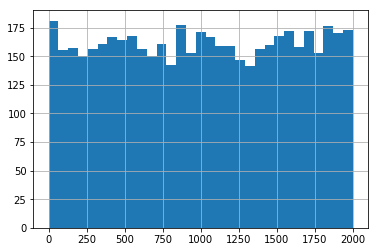

In [12]:
df_reps["alpha_order_stat"].hist(bins=31);

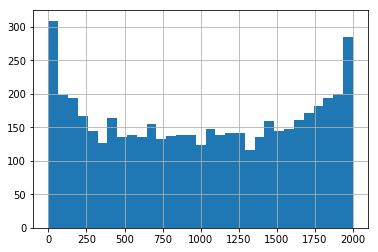

In [13]:
df_reps["beta_order_stat"].hist(bins=31);

# Correct prior

In [14]:
def gen_func(X):
    beta = np.random.randn()*10.
    alpha = np.random.randn()*10.
    y = np.random.normal(X*beta + alpha, 1.2)
    return beta, alpha, y


b, a, y0 = gen_func(X)

In [15]:
Xshared = theano.shared(X)
yshared = theano.shared(y0)

with pm.Model() as wide_lin_regr2:
    beta = pm.Normal('beta', 0., 10.)
    alpha = pm.Normal('alpha', 0., 10.)
    y = pm.Normal('y', Xshared*beta + alpha, 1.2, observed=yshared)

In [16]:
%%time
trace = pm.sample(model=wide_lin_regr2)

100%|██████████| 1000/1000 [00:00<00:00, 1492.49it/s]


CPU times: user 624 ms, sys: 48 ms, total: 672 ms
Wall time: 1.43 s


In [17]:
reps = np.zeros((num_reps, 12))
for i in range(num_reps):
    b, a, y = gen_func(X)
    yshared.set_value(y)
    trace = pm.sample(model=wide_lin_regr2, progressbar=False,
                      compute_convergence_checks=False)
    eff_n = pm.effective_n(trace)
    rhat = pm.gelman_rubin(trace)
    reps[i] = np.asarray([eff_n['alpha'], order_stat(a, trace['alpha']), a,
                          rhat['alpha'], rmse_averaged(a, trace['alpha']),
                          rmse_mean(a, trace['alpha']),
                          eff_n['beta'], order_stat(b, trace['beta']), b,
                          rhat['beta'], rmse_averaged(b, trace['beta']),
                          rmse_mean(b, trace['beta'])
                          ])

In [18]:
df_reps = pd.DataFrame(reps, columns=['alpha_n_eff', 'alpha_order_stat', 'alpha_prior',
                                      'alpha_rhat', 'alpha_rmse_averaged', 'alpha_rmse_mean',
                                      'beta_n_eff', 'beta_order_stat', 'beta_prior', 
                                      'beta_rhat', 'beta_rmse_averaged', 'beta_rmse_mean'])
df_reps.head()

,alpha_n_eff,alpha_order_stat,alpha_prior,alpha_rhat,alpha_rmse_averaged,alpha_rmse_mean,beta_n_eff,beta_order_stat,beta_prior,beta_rhat,beta_rmse_averaged,beta_rmse_mean
0,1147.606319,528.0,9.883820,0.999358,0.291929,0.150153,1281.350549,580.0,25.889843,0.999648,0.078521,0.037371
1,1853.711481,698.0,2.229558,0.999948,0.274593,0.097905,1886.417438,410.0,1.708234,0.999826,0.090273,0.058346
2,1850.700404,243.0,-5.518517,0.999459,0.400759,0.304994,1819.130871,1310.0,-0.303989,0.999429,0.075969,0.029479
3,1419.050595,406.0,-11.273218,1.000875,0.327103,0.214998,1578.612660,1462.0,-13.491061,1.002117,0.078110,0.041719
4,1720.717174,1656.0,7.102479,0.999976,0.348729,0.238448,1528.898395,266.0,-5.453914,0.999647,0.100322,0.073927


In [19]:
L = len(trace['alpha'])

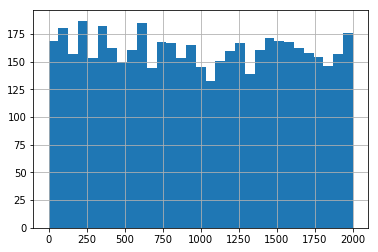

In [20]:
df_reps["alpha_order_stat"].hist(bins=31);

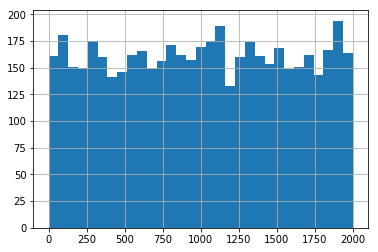

In [21]:
df_reps["beta_order_stat"].hist(bins=31);

# VSBC

In [22]:
cb = [
    pm.callbacks.CheckParametersConvergence(
        tolerance=1e-2, diff='absolute'),
    pm.callbacks.CheckParametersConvergence(
        tolerance=1e-2, diff='relative'),
]
approx = pm.fit(
            n=100000, method='advi', model=wide_lin_regr2,
            callbacks=cb,
            progressbar=False,
            obj_optimizer=pm.adagrad_window,
        )
trace = approx.sample(1000)

Convergence archived at 15000
Interrupted at 14,999 [14%]: Average Loss = 74,842


In [23]:
reps = np.zeros((num_reps, 8))
for i in range(num_reps):
    b, a, y = gen_func(X)
    yshared.set_value(y)
    approx = pm.fit(
            n=100000, method='advi', model=wide_lin_regr2,
            callbacks=cb,
            progressbar=False,
            obj_optimizer=pm.adadelta,
        )
    trace = approx.sample(1000)
    reps[i] = np.asarray([order_stat(a, trace['alpha']), a,
                          rmse_averaged(a, trace['alpha']),
                          rmse_mean(a, trace['alpha']),
                          order_stat(b, trace['beta']), b,
                          rmse_averaged(b, trace['beta']),
                          rmse_mean(b, trace['beta'])
                          ])

Convergence archived at 5100
Interrupted at 5,099 [5%]: Average Loss = 2,653.5
Convergence archived at 4700
Interrupted at 4,699 [4%]: Average Loss = 764.91
Convergence archived at 5700
Interrupted at 5,699 [5%]: Average Loss = 2,475.3
Convergence archived at 2900
Interrupted at 2,899 [2%]: Average Loss = 87.547
Convergence archived at 4700
Interrupted at 4,699 [4%]: Average Loss = 3,372.1
Convergence archived at 3800
Interrupted at 3,799 [3%]: Average Loss = 307.69
Convergence archived at 3800
Interrupted at 3,799 [3%]: Average Loss = 58.243
Convergence archived at 4900
Interrupted at 4,899 [4%]: Average Loss = 1,508.4
Convergence archived at 4800
Interrupted at 4,799 [4%]: Average Loss = 1,413
Convergence archived at 3800
Interrupted at 3,799 [3%]: Average Loss = 212.9
Convergence archived at 3600
Interrupted at 3,599 [3%]: Average Loss = 210.67
Convergence archived at 4800
Interrupted at 4,799 [4%]: Average Loss = 2,219.6
Convergence archived at 3000
Interrupted at 2,999 [2%]: Avera

Convergence archived at 5000
Interrupted at 4,999 [4%]: Average Loss = 2,272.6
Convergence archived at 4900
Interrupted at 4,899 [4%]: Average Loss = 1,563.6
Convergence archived at 5200
Interrupted at 5,199 [5%]: Average Loss = 5,194
Convergence archived at 4500
Interrupted at 4,499 [4%]: Average Loss = 551.02
Convergence archived at 3800
Interrupted at 3,799 [3%]: Average Loss = 1,115.1
Convergence archived at 5500
Interrupted at 5,499 [5%]: Average Loss = 2,953.2
Convergence archived at 4000
Interrupted at 3,999 [3%]: Average Loss = 1,279.6
Convergence archived at 4700
Interrupted at 4,699 [4%]: Average Loss = 3,416.6
Convergence archived at 3700
Interrupted at 3,699 [3%]: Average Loss = 165.51
Convergence archived at 4600
Interrupted at 4,599 [4%]: Average Loss = 988.26
Convergence archived at 4100
Interrupted at 4,099 [4%]: Average Loss = 393.31
Convergence archived at 4100
Interrupted at 4,099 [4%]: Average Loss = 91.205
Convergence archived at 3600
Interrupted at 3,599 [3%]: Ave

Convergence archived at 5000
Interrupted at 4,999 [4%]: Average Loss = 3,527.9
Convergence archived at 4500
Interrupted at 4,499 [4%]: Average Loss = 322.04
Convergence archived at 6400
Interrupted at 6,399 [6%]: Average Loss = 14,797
Convergence archived at 4200
Interrupted at 4,199 [4%]: Average Loss = 570.69
Convergence archived at 8100
Interrupted at 8,099 [8%]: Average Loss = 1,839.6
Convergence archived at 4600
Interrupted at 4,599 [4%]: Average Loss = 1,289.1
Convergence archived at 4700
Interrupted at 4,699 [4%]: Average Loss = 3,066.4
Convergence archived at 3600
Interrupted at 3,599 [3%]: Average Loss = 76.042
Convergence archived at 4600
Interrupted at 4,599 [4%]: Average Loss = 185.12
Convergence archived at 4700
Interrupted at 4,699 [4%]: Average Loss = 3,216.5
Convergence archived at 4500
Interrupted at 4,499 [4%]: Average Loss = 648.3
Convergence archived at 4000
Interrupted at 3,999 [3%]: Average Loss = 391.44
Convergence archived at 3400
Interrupted at 3,399 [3%]: Aver

Convergence archived at 5700
Interrupted at 5,699 [5%]: Average Loss = 10,419
Convergence archived at 4400
Interrupted at 4,399 [4%]: Average Loss = 1,134.8
Convergence archived at 3800
Interrupted at 3,799 [3%]: Average Loss = 163.5
Convergence archived at 3300
Interrupted at 3,299 [3%]: Average Loss = 252.87
Convergence archived at 4100
Interrupted at 4,099 [4%]: Average Loss = 1,827.1
Convergence archived at 4600
Interrupted at 4,599 [4%]: Average Loss = 1,810.2
Convergence archived at 3400
Interrupted at 3,399 [3%]: Average Loss = 80.163
Convergence archived at 3800
Interrupted at 3,799 [3%]: Average Loss = 140.38
Convergence archived at 3000
Interrupted at 2,999 [2%]: Average Loss = 282.64
Convergence archived at 5200
Interrupted at 5,199 [5%]: Average Loss = 1,460.9
Convergence archived at 3600
Interrupted at 3,599 [3%]: Average Loss = 401.33
Convergence archived at 3700
Interrupted at 3,699 [3%]: Average Loss = 352.79
Convergence archived at 4200
Interrupted at 4,199 [4%]: Avera

Convergence archived at 4700
Interrupted at 4,699 [4%]: Average Loss = 2,404.6
Convergence archived at 3600
Interrupted at 3,599 [3%]: Average Loss = 357.15
Convergence archived at 3800
Interrupted at 3,799 [3%]: Average Loss = 234.13
Convergence archived at 4200
Interrupted at 4,199 [4%]: Average Loss = 509.42
Convergence archived at 8900
Interrupted at 8,899 [8%]: Average Loss = 638.92
Convergence archived at 4600
Interrupted at 4,599 [4%]: Average Loss = 1,433.2
Convergence archived at 4200
Interrupted at 4,199 [4%]: Average Loss = 233.47
Convergence archived at 3600
Interrupted at 3,599 [3%]: Average Loss = 284.15
Convergence archived at 3900
Interrupted at 3,899 [3%]: Average Loss = 583.65
Convergence archived at 4200
Interrupted at 4,199 [4%]: Average Loss = 382.06
Convergence archived at 3400
Interrupted at 3,399 [3%]: Average Loss = 332.15
Convergence archived at 4000
Interrupted at 3,999 [3%]: Average Loss = 1,353.8
Convergence archived at 4400
Interrupted at 4,399 [4%]: Avera

Convergence archived at 3400
Interrupted at 3,399 [3%]: Average Loss = 107.21
Convergence archived at 5000
Interrupted at 4,999 [4%]: Average Loss = 5,179.5
Convergence archived at 5000
Interrupted at 4,999 [4%]: Average Loss = 3,317.5
Convergence archived at 4400
Interrupted at 4,399 [4%]: Average Loss = 1,990.7
Convergence archived at 6200
Interrupted at 6,199 [6%]: Average Loss = 2,821.6
Convergence archived at 3300
Interrupted at 3,299 [3%]: Average Loss = 170.5
Convergence archived at 3100
Interrupted at 3,099 [3%]: Average Loss = 78.393
Convergence archived at 3200
Interrupted at 3,199 [3%]: Average Loss = 105.66
Convergence archived at 3800
Interrupted at 3,799 [3%]: Average Loss = 800.51
Convergence archived at 5600
Interrupted at 5,599 [5%]: Average Loss = 2,948.6
Convergence archived at 4300
Interrupted at 4,299 [4%]: Average Loss = 569.34
Convergence archived at 4700
Interrupted at 4,699 [4%]: Average Loss = 2,923.4
Convergence archived at 4200
Interrupted at 4,199 [4%]: Ave

Convergence archived at 4500
Interrupted at 4,499 [4%]: Average Loss = 281.36
Convergence archived at 4300
Interrupted at 4,299 [4%]: Average Loss = 820.08
Convergence archived at 5800
Interrupted at 5,799 [5%]: Average Loss = 828.97
Convergence archived at 4100
Interrupted at 4,099 [4%]: Average Loss = 1,163.5
Convergence archived at 4900
Interrupted at 4,899 [4%]: Average Loss = 537.78
Convergence archived at 4100
Interrupted at 4,099 [4%]: Average Loss = 782.93
Convergence archived at 4300
Interrupted at 4,299 [4%]: Average Loss = 2,688.3
Convergence archived at 3800
Interrupted at 3,799 [3%]: Average Loss = 722.19
Convergence archived at 5400
Interrupted at 5,399 [5%]: Average Loss = 3,998.3
Convergence archived at 3300
Interrupted at 3,299 [3%]: Average Loss = 234.12
Convergence archived at 3700
Interrupted at 3,699 [3%]: Average Loss = 208.27
Convergence archived at 4800
Interrupted at 4,799 [4%]: Average Loss = 3,232.6
Convergence archived at 3800
Interrupted at 3,799 [3%]: Aver

Convergence archived at 4100
Interrupted at 4,099 [4%]: Average Loss = 971.44
Convergence archived at 5200
Interrupted at 5,199 [5%]: Average Loss = 1,672.3
Convergence archived at 4100
Interrupted at 4,099 [4%]: Average Loss = 616.57
Convergence archived at 6000
Interrupted at 5,999 [5%]: Average Loss = 3,932
Convergence archived at 3500
Interrupted at 3,499 [3%]: Average Loss = 379.85
Convergence archived at 3800
Interrupted at 3,799 [3%]: Average Loss = 412.04
Convergence archived at 5800
Interrupted at 5,799 [5%]: Average Loss = 9,825.8
Convergence archived at 5300
Interrupted at 5,299 [5%]: Average Loss = 3,789.9
Convergence archived at 5200
Interrupted at 5,199 [5%]: Average Loss = 2,284
Convergence archived at 3800
Interrupted at 3,799 [3%]: Average Loss = 1,543.5
Convergence archived at 4000
Interrupted at 3,999 [3%]: Average Loss = 589.84
Convergence archived at 3800
Interrupted at 3,799 [3%]: Average Loss = 256.4
Convergence archived at 4400
Interrupted at 4,399 [4%]: Average

Convergence archived at 4100
Interrupted at 4,099 [4%]: Average Loss = 575.14
Convergence archived at 4000
Interrupted at 3,999 [3%]: Average Loss = 429.84
Convergence archived at 4900
Interrupted at 4,899 [4%]: Average Loss = 783.74
Convergence archived at 4300
Interrupted at 4,299 [4%]: Average Loss = 219.76
Convergence archived at 5200
Interrupted at 5,199 [5%]: Average Loss = 7,814.2
Convergence archived at 4200
Interrupted at 4,199 [4%]: Average Loss = 770.5
Convergence archived at 4700
Interrupted at 4,699 [4%]: Average Loss = 2,152.3
Convergence archived at 6000
Interrupted at 5,999 [5%]: Average Loss = 2,486.8
Convergence archived at 3300
Interrupted at 3,299 [3%]: Average Loss = 154.03
Convergence archived at 2700
Interrupted at 2,699 [2%]: Average Loss = 89.042
Convergence archived at 3300
Interrupted at 3,299 [3%]: Average Loss = 374.08
Convergence archived at 4100
Interrupted at 4,099 [4%]: Average Loss = 357.37
Convergence archived at 4600
Interrupted at 4,599 [4%]: Averag

Convergence archived at 5600
Interrupted at 5,599 [5%]: Average Loss = 5,987.7
Convergence archived at 4300
Interrupted at 4,299 [4%]: Average Loss = 2,055.2
Convergence archived at 3800
Interrupted at 3,799 [3%]: Average Loss = 523.49
Convergence archived at 4500
Interrupted at 4,499 [4%]: Average Loss = 1,163.5
Convergence archived at 3900
Interrupted at 3,899 [3%]: Average Loss = 937.81
Convergence archived at 3500
Interrupted at 3,499 [3%]: Average Loss = 529.93
Convergence archived at 5000
Interrupted at 4,999 [4%]: Average Loss = 1,498.2
Convergence archived at 4100
Interrupted at 4,099 [4%]: Average Loss = 1,244.1
Convergence archived at 5400
Interrupted at 5,399 [5%]: Average Loss = 5,947
Convergence archived at 3700
Interrupted at 3,699 [3%]: Average Loss = 142.23
Convergence archived at 3200
Interrupted at 3,199 [3%]: Average Loss = 113.67
Convergence archived at 4300
Interrupted at 4,299 [4%]: Average Loss = 75.152
Convergence archived at 3500
Interrupted at 3,499 [3%]: Aver

Convergence archived at 3400
Interrupted at 3,399 [3%]: Average Loss = 192.55
Convergence archived at 4700
Interrupted at 4,699 [4%]: Average Loss = 4,631.7
Convergence archived at 5400
Interrupted at 5,399 [5%]: Average Loss = 4,085.5
Convergence archived at 3800
Interrupted at 3,799 [3%]: Average Loss = 438.25
Convergence archived at 5400
Interrupted at 5,399 [5%]: Average Loss = 1,093.7
Convergence archived at 3900
Interrupted at 3,899 [3%]: Average Loss = 286.21
Convergence archived at 4800
Interrupted at 4,799 [4%]: Average Loss = 2,970.8
Convergence archived at 4900
Interrupted at 4,899 [4%]: Average Loss = 54.166
Convergence archived at 4800
Interrupted at 4,799 [4%]: Average Loss = 2,067.4
Convergence archived at 3100
Interrupted at 3,099 [3%]: Average Loss = 174.62
Convergence archived at 4200
Interrupted at 4,199 [4%]: Average Loss = 1,307.9
Convergence archived at 4800
Interrupted at 4,799 [4%]: Average Loss = 3,547
Convergence archived at 5700
Interrupted at 5,699 [5%]: Ave

Convergence archived at 4000
Interrupted at 3,999 [3%]: Average Loss = 423.77
Convergence archived at 4300
Interrupted at 4,299 [4%]: Average Loss = 2,000.3
Convergence archived at 4600
Interrupted at 4,599 [4%]: Average Loss = 2,070
Convergence archived at 5300
Interrupted at 5,299 [5%]: Average Loss = 5,968
Convergence archived at 3000
Interrupted at 2,999 [2%]: Average Loss = 63.323
Convergence archived at 5500
Interrupted at 5,499 [5%]: Average Loss = 1,337.8
Convergence archived at 3700
Interrupted at 3,699 [3%]: Average Loss = 184.73
Convergence archived at 4600
Interrupted at 4,599 [4%]: Average Loss = 3,929.8
Convergence archived at 4000
Interrupted at 3,999 [3%]: Average Loss = 338.44
Convergence archived at 5500
Interrupted at 5,499 [5%]: Average Loss = 7,821.3
Convergence archived at 4200
Interrupted at 4,199 [4%]: Average Loss = 602.72
Convergence archived at 3800
Interrupted at 3,799 [3%]: Average Loss = 627.24
Convergence archived at 3800
Interrupted at 3,799 [3%]: Averag

Convergence archived at 6400
Interrupted at 6,399 [6%]: Average Loss = 10,728
Convergence archived at 4100
Interrupted at 4,099 [4%]: Average Loss = 485.56
Convergence archived at 4200
Interrupted at 4,199 [4%]: Average Loss = 754.37
Convergence archived at 3200
Interrupted at 3,199 [3%]: Average Loss = 228.53
Convergence archived at 3800
Interrupted at 3,799 [3%]: Average Loss = 1,147.3
Convergence archived at 5900
Interrupted at 5,899 [5%]: Average Loss = 4,345.4
Convergence archived at 6400
Interrupted at 6,399 [6%]: Average Loss = 18,576
Convergence archived at 3600
Interrupted at 3,599 [3%]: Average Loss = 300.85
Convergence archived at 5400
Interrupted at 5,399 [5%]: Average Loss = 1,150.3
Convergence archived at 5700
Interrupted at 5,699 [5%]: Average Loss = 13,344
Convergence archived at 4300
Interrupted at 4,299 [4%]: Average Loss = 636.2
Convergence archived at 4100
Interrupted at 4,099 [4%]: Average Loss = 1,042.4
Convergence archived at 3300
Interrupted at 3,299 [3%]: Avera

Convergence archived at 4100
Interrupted at 4,099 [4%]: Average Loss = 1,256.9
Convergence archived at 3400
Interrupted at 3,399 [3%]: Average Loss = 386.23
Convergence archived at 5800
Interrupted at 5,799 [5%]: Average Loss = 2,993.9
Convergence archived at 6200
Interrupted at 6,199 [6%]: Average Loss = 3,268.3
Convergence archived at 3100
Interrupted at 3,099 [3%]: Average Loss = 104.07
Convergence archived at 3800
Interrupted at 3,799 [3%]: Average Loss = 176.06
Convergence archived at 4300
Interrupted at 4,299 [4%]: Average Loss = 512.98
Convergence archived at 4200
Interrupted at 4,199 [4%]: Average Loss = 1,112.2
Convergence archived at 5000
Interrupted at 4,999 [4%]: Average Loss = 3,351.7
Convergence archived at 2900
Interrupted at 2,899 [2%]: Average Loss = 107.92
Convergence archived at 4800
Interrupted at 4,799 [4%]: Average Loss = 1,904.1
Convergence archived at 4400
Interrupted at 4,399 [4%]: Average Loss = 1,764.4
Convergence archived at 5600
Interrupted at 5,599 [5%]: A

Convergence archived at 3800
Interrupted at 3,799 [3%]: Average Loss = 871.2
Convergence archived at 4900
Interrupted at 4,899 [4%]: Average Loss = 191.73
Convergence archived at 4000
Interrupted at 3,999 [3%]: Average Loss = 1,041.9
Convergence archived at 4700
Interrupted at 4,699 [4%]: Average Loss = 2,460.1
Convergence archived at 4000
Interrupted at 3,999 [3%]: Average Loss = 1,320.6
Convergence archived at 3800
Interrupted at 3,799 [3%]: Average Loss = 326.03
Convergence archived at 4000
Interrupted at 3,999 [3%]: Average Loss = 1,078.2
Convergence archived at 6200
Interrupted at 6,199 [6%]: Average Loss = 13,416
Convergence archived at 4100
Interrupted at 4,099 [4%]: Average Loss = 408.44
Convergence archived at 3600
Interrupted at 3,599 [3%]: Average Loss = 627.86
Convergence archived at 4600
Interrupted at 4,599 [4%]: Average Loss = 690.22
Convergence archived at 5300
Interrupted at 5,299 [5%]: Average Loss = 1,863
Convergence archived at 4300
Interrupted at 4,299 [4%]: Averag

Convergence archived at 4300
Interrupted at 4,299 [4%]: Average Loss = 371.09
Convergence archived at 3900
Interrupted at 3,899 [3%]: Average Loss = 651.34
Convergence archived at 3500
Interrupted at 3,499 [3%]: Average Loss = 152.29
Convergence archived at 5100
Interrupted at 5,099 [5%]: Average Loss = 5,380
Convergence archived at 3600
Interrupted at 3,599 [3%]: Average Loss = 251.31
Convergence archived at 3200
Interrupted at 3,199 [3%]: Average Loss = 88.261
Convergence archived at 3900
Interrupted at 3,899 [3%]: Average Loss = 222.03
Convergence archived at 3300
Interrupted at 3,299 [3%]: Average Loss = 94.522
Convergence archived at 4000
Interrupted at 3,999 [3%]: Average Loss = 1,636.5
Convergence archived at 3500
Interrupted at 3,499 [3%]: Average Loss = 70.102
Convergence archived at 4100
Interrupted at 4,099 [4%]: Average Loss = 1,134.3
Convergence archived at 3200
Interrupted at 3,199 [3%]: Average Loss = 213.89
Convergence archived at 4900
Interrupted at 4,899 [4%]: Average

Convergence archived at 5800
Interrupted at 5,799 [5%]: Average Loss = 150.9
Convergence archived at 5300
Interrupted at 5,299 [5%]: Average Loss = 5,924.7
Convergence archived at 3400
Interrupted at 3,399 [3%]: Average Loss = 410.09
Convergence archived at 3800
Interrupted at 3,799 [3%]: Average Loss = 567.06
Convergence archived at 3200
Interrupted at 3,199 [3%]: Average Loss = 135.04
Convergence archived at 3200
Interrupted at 3,199 [3%]: Average Loss = 330.31
Convergence archived at 3700
Interrupted at 3,699 [3%]: Average Loss = 135.5
Convergence archived at 4800
Interrupted at 4,799 [4%]: Average Loss = 2,783.3
Convergence archived at 4200
Interrupted at 4,199 [4%]: Average Loss = 343.62
Convergence archived at 4400
Interrupted at 4,399 [4%]: Average Loss = 879.87
Convergence archived at 3500
Interrupted at 3,499 [3%]: Average Loss = 264.31
Convergence archived at 3900
Interrupted at 3,899 [3%]: Average Loss = 501.33
Convergence archived at 4700
Interrupted at 4,699 [4%]: Average 

Convergence archived at 5000
Interrupted at 4,999 [4%]: Average Loss = 3,657.6
Convergence archived at 4200
Interrupted at 4,199 [4%]: Average Loss = 1,645.9
Convergence archived at 3100
Interrupted at 3,099 [3%]: Average Loss = 96.837
Convergence archived at 4800
Interrupted at 4,799 [4%]: Average Loss = 2,111.8
Convergence archived at 6700
Interrupted at 6,699 [6%]: Average Loss = 20,153
Convergence archived at 6300
Interrupted at 6,299 [6%]: Average Loss = 18,942
Convergence archived at 4400
Interrupted at 4,399 [4%]: Average Loss = 50.466
Convergence archived at 3900
Interrupted at 3,899 [3%]: Average Loss = 1,145.6
Convergence archived at 5100
Interrupted at 5,099 [5%]: Average Loss = 751.54
Convergence archived at 4500
Interrupted at 4,499 [4%]: Average Loss = 578.73
Convergence archived at 4700
Interrupted at 4,699 [4%]: Average Loss = 1,852.3
Convergence archived at 6900
Interrupted at 6,899 [6%]: Average Loss = 17,504
Convergence archived at 5000
Interrupted at 4,999 [4%]: Ave

Convergence archived at 3800
Interrupted at 3,799 [3%]: Average Loss = 384.65
Convergence archived at 5400
Interrupted at 5,399 [5%]: Average Loss = 4,651.9
Convergence archived at 6900
Interrupted at 6,899 [6%]: Average Loss = 12,353
Convergence archived at 3500
Interrupted at 3,499 [3%]: Average Loss = 307.09
Convergence archived at 2900
Interrupted at 2,899 [2%]: Average Loss = 72.796
Convergence archived at 3900
Interrupted at 3,899 [3%]: Average Loss = 607.09
Convergence archived at 4400
Interrupted at 4,399 [4%]: Average Loss = 971.08
Convergence archived at 3200
Interrupted at 3,199 [3%]: Average Loss = 265.98
Convergence archived at 4300
Interrupted at 4,299 [4%]: Average Loss = 1,942.8
Convergence archived at 4200
Interrupted at 4,199 [4%]: Average Loss = 2,635.2
Convergence archived at 3100
Interrupted at 3,099 [3%]: Average Loss = 79.681
Convergence archived at 6000
Interrupted at 5,999 [5%]: Average Loss = 1,043.1
Convergence archived at 4500
Interrupted at 4,499 [4%]: Aver

Convergence archived at 4800
Interrupted at 4,799 [4%]: Average Loss = 3,681.3
Convergence archived at 4200
Interrupted at 4,199 [4%]: Average Loss = 1,624
Convergence archived at 5300
Interrupted at 5,299 [5%]: Average Loss = 1,586
Convergence archived at 6500
Interrupted at 6,499 [6%]: Average Loss = 64.613
Convergence archived at 5700
Interrupted at 5,699 [5%]: Average Loss = 2,577.7
Convergence archived at 5600
Interrupted at 5,599 [5%]: Average Loss = 5,262.3
Convergence archived at 4800
Interrupted at 4,799 [4%]: Average Loss = 4,285.8
Convergence archived at 5500
Interrupted at 5,499 [5%]: Average Loss = 992.29
Convergence archived at 3800
Interrupted at 3,799 [3%]: Average Loss = 52.312
Convergence archived at 3700
Interrupted at 3,699 [3%]: Average Loss = 68.609
Convergence archived at 3200
Interrupted at 3,199 [3%]: Average Loss = 88.078
Convergence archived at 5600
Interrupted at 5,599 [5%]: Average Loss = 4,495.9
Convergence archived at 4500
Interrupted at 4,499 [4%]: Avera

Convergence archived at 3200
Interrupted at 3,199 [3%]: Average Loss = 191.67
Convergence archived at 4100
Interrupted at 4,099 [4%]: Average Loss = 113.37
Convergence archived at 3500
Interrupted at 3,499 [3%]: Average Loss = 684.27
Convergence archived at 4800
Interrupted at 4,799 [4%]: Average Loss = 3,344.8
Convergence archived at 3000
Interrupted at 2,999 [2%]: Average Loss = 211.26
Convergence archived at 3300
Interrupted at 3,299 [3%]: Average Loss = 301.22
Convergence archived at 4500
Interrupted at 4,499 [4%]: Average Loss = 173.62
Convergence archived at 3600
Interrupted at 3,599 [3%]: Average Loss = 245.77
Convergence archived at 2900
Interrupted at 2,899 [2%]: Average Loss = 71.38
Convergence archived at 4600
Interrupted at 4,599 [4%]: Average Loss = 1,287.9
Convergence archived at 6400
Interrupted at 6,399 [6%]: Average Loss = 8,465.5
Convergence archived at 6100
Interrupted at 6,099 [6%]: Average Loss = 9,230.3
Convergence archived at 4800
Interrupted at 4,799 [4%]: Avera

Convergence archived at 3900
Interrupted at 3,899 [3%]: Average Loss = 738.74
Convergence archived at 3300
Interrupted at 3,299 [3%]: Average Loss = 300.94
Convergence archived at 4600
Interrupted at 4,599 [4%]: Average Loss = 517.98
Convergence archived at 4100
Interrupted at 4,099 [4%]: Average Loss = 1,260.5
Convergence archived at 3800
Interrupted at 3,799 [3%]: Average Loss = 634.03
Convergence archived at 3800
Interrupted at 3,799 [3%]: Average Loss = 71.884
Convergence archived at 6700
Interrupted at 6,699 [6%]: Average Loss = 14,953
Convergence archived at 3800
Interrupted at 3,799 [3%]: Average Loss = 155.96
Convergence archived at 3400
Interrupted at 3,399 [3%]: Average Loss = 113.47
Convergence archived at 4300
Interrupted at 4,299 [4%]: Average Loss = 657.91
Convergence archived at 3800
Interrupted at 3,799 [3%]: Average Loss = 602.17
Convergence archived at 3200
Interrupted at 3,199 [3%]: Average Loss = 366.41
Convergence archived at 4500
Interrupted at 4,499 [4%]: Average

Convergence archived at 3800
Interrupted at 3,799 [3%]: Average Loss = 284.76
Convergence archived at 5400
Interrupted at 5,399 [5%]: Average Loss = 1,516.8
Convergence archived at 4600
Interrupted at 4,599 [4%]: Average Loss = 3,101.8
Convergence archived at 4000
Interrupted at 3,999 [3%]: Average Loss = 1,095.8
Convergence archived at 4100
Interrupted at 4,099 [4%]: Average Loss = 1,931.6
Convergence archived at 4800
Interrupted at 4,799 [4%]: Average Loss = 2,752
Convergence archived at 4800
Interrupted at 4,799 [4%]: Average Loss = 2,091
Convergence archived at 4900
Interrupted at 4,899 [4%]: Average Loss = 465.3
Convergence archived at 3500
Interrupted at 3,499 [3%]: Average Loss = 314
Convergence archived at 3900
Interrupted at 3,899 [3%]: Average Loss = 515.99
Convergence archived at 9300
Interrupted at 9,299 [9%]: Average Loss = 443.54
Convergence archived at 4100
Interrupted at 4,099 [4%]: Average Loss = 550.12
Convergence archived at 4500
Interrupted at 4,499 [4%]: Average Lo

Convergence archived at 4500
Interrupted at 4,499 [4%]: Average Loss = 1,157.4
Convergence archived at 4600
Interrupted at 4,599 [4%]: Average Loss = 1,253.6
Convergence archived at 6200
Interrupted at 6,199 [6%]: Average Loss = 1,890.5
Convergence archived at 4500
Interrupted at 4,499 [4%]: Average Loss = 1,408.3
Convergence archived at 4500
Interrupted at 4,499 [4%]: Average Loss = 1,066.3
Convergence archived at 5500
Interrupted at 5,499 [5%]: Average Loss = 7,517.6
Convergence archived at 4800
Interrupted at 4,799 [4%]: Average Loss = 2,512.5
Convergence archived at 5100
Interrupted at 5,099 [5%]: Average Loss = 3,406.9
Convergence archived at 4500
Interrupted at 4,499 [4%]: Average Loss = 618.24
Convergence archived at 4200
Interrupted at 4,199 [4%]: Average Loss = 1,121.3
Convergence archived at 3200
Interrupted at 3,199 [3%]: Average Loss = 319.6
Convergence archived at 3600
Interrupted at 3,599 [3%]: Average Loss = 313.87
Convergence archived at 5600
Interrupted at 5,599 [5%]: 

Convergence archived at 7800
Interrupted at 7,799 [7%]: Average Loss = 448.25
Convergence archived at 3300
Interrupted at 3,299 [3%]: Average Loss = 91.471
Convergence archived at 4300
Interrupted at 4,299 [4%]: Average Loss = 1,076.7
Convergence archived at 4000
Interrupted at 3,999 [3%]: Average Loss = 538.39
Convergence archived at 3100
Interrupted at 3,099 [3%]: Average Loss = 208.69
Convergence archived at 5400
Interrupted at 5,399 [5%]: Average Loss = 2,302.1
Convergence archived at 5700
Interrupted at 5,699 [5%]: Average Loss = 6,847.3
Convergence archived at 2900
Interrupted at 2,899 [2%]: Average Loss = 60.203
Convergence archived at 3300
Interrupted at 3,299 [3%]: Average Loss = 89.871
Convergence archived at 3500
Interrupted at 3,499 [3%]: Average Loss = 206.81
Convergence archived at 3700
Interrupted at 3,699 [3%]: Average Loss = 668.44
Convergence archived at 5800
Interrupted at 5,799 [5%]: Average Loss = 10,402
Convergence archived at 4300
Interrupted at 4,299 [4%]: Avera

Convergence archived at 3900
Interrupted at 3,899 [3%]: Average Loss = 703.6
Convergence archived at 3800
Interrupted at 3,799 [3%]: Average Loss = 165.52
Convergence archived at 5100
Interrupted at 5,099 [5%]: Average Loss = 3,980
Convergence archived at 4500
Interrupted at 4,499 [4%]: Average Loss = 1,604.5
Convergence archived at 4600
Interrupted at 4,599 [4%]: Average Loss = 868.21
Convergence archived at 4800
Interrupted at 4,799 [4%]: Average Loss = 424.91
Convergence archived at 4500
Interrupted at 4,499 [4%]: Average Loss = 1,701.2
Convergence archived at 4500
Interrupted at 4,499 [4%]: Average Loss = 1,261.2
Convergence archived at 4900
Interrupted at 4,899 [4%]: Average Loss = 1,408.8
Convergence archived at 4100
Interrupted at 4,099 [4%]: Average Loss = 320.18
Convergence archived at 4100
Interrupted at 4,099 [4%]: Average Loss = 1,483.8
Convergence archived at 3200
Interrupted at 3,199 [3%]: Average Loss = 317.32
Convergence archived at 4500
Interrupted at 4,499 [4%]: Avera

Convergence archived at 4300
Interrupted at 4,299 [4%]: Average Loss = 2,462.9
Convergence archived at 5100
Interrupted at 5,099 [5%]: Average Loss = 2,652.2
Convergence archived at 5800
Interrupted at 5,799 [5%]: Average Loss = 5,922.4
Convergence archived at 5100
Interrupted at 5,099 [5%]: Average Loss = 2,723.5
Convergence archived at 5300
Interrupted at 5,299 [5%]: Average Loss = 355.38
Convergence archived at 6400
Interrupted at 6,399 [6%]: Average Loss = 7,645
Convergence archived at 4900
Interrupted at 4,899 [4%]: Average Loss = 1,791.4
Convergence archived at 5500
Interrupted at 5,499 [5%]: Average Loss = 4,355
Convergence archived at 3200
Interrupted at 3,199 [3%]: Average Loss = 123.21
Convergence archived at 4600
Interrupted at 4,599 [4%]: Average Loss = 1,836.3
Convergence archived at 4600
Interrupted at 4,599 [4%]: Average Loss = 688.97
Convergence archived at 3400
Interrupted at 3,399 [3%]: Average Loss = 69.374
Convergence archived at 4700
Interrupted at 4,699 [4%]: Aver

Convergence archived at 3900
Interrupted at 3,899 [3%]: Average Loss = 933.11
Convergence archived at 4100
Interrupted at 4,099 [4%]: Average Loss = 324.63
Convergence archived at 4100
Interrupted at 4,099 [4%]: Average Loss = 382.88
Convergence archived at 6200
Interrupted at 6,199 [6%]: Average Loss = 50.473
Convergence archived at 4600
Interrupted at 4,599 [4%]: Average Loss = 1,346
Convergence archived at 4200
Interrupted at 4,199 [4%]: Average Loss = 491.58
Convergence archived at 3800
Interrupted at 3,799 [3%]: Average Loss = 268.82
Convergence archived at 5300
Interrupted at 5,299 [5%]: Average Loss = 2,590
Convergence archived at 3200
Interrupted at 3,199 [3%]: Average Loss = 315.62
Convergence archived at 5700
Interrupted at 5,699 [5%]: Average Loss = 129.12
Convergence archived at 3300
Interrupted at 3,299 [3%]: Average Loss = 188.76
Convergence archived at 4700
Interrupted at 4,699 [4%]: Average Loss = 1,633.6
Convergence archived at 4300
Interrupted at 4,299 [4%]: Average L

Convergence archived at 5800
Interrupted at 5,799 [5%]: Average Loss = 185.72
Convergence archived at 4600
Interrupted at 4,599 [4%]: Average Loss = 3,064.7
Convergence archived at 5400
Interrupted at 5,399 [5%]: Average Loss = 3,744.3
Convergence archived at 3700
Interrupted at 3,699 [3%]: Average Loss = 256.43
Convergence archived at 4000
Interrupted at 3,999 [3%]: Average Loss = 141.76
Convergence archived at 5100
Interrupted at 5,099 [5%]: Average Loss = 3,615
Convergence archived at 4100
Interrupted at 4,099 [4%]: Average Loss = 740.01
Convergence archived at 3800
Interrupted at 3,799 [3%]: Average Loss = 1,291.8
Convergence archived at 5000
Interrupted at 4,999 [4%]: Average Loss = 1,155.5
Convergence archived at 3600
Interrupted at 3,599 [3%]: Average Loss = 170.76
Convergence archived at 3900
Interrupted at 3,899 [3%]: Average Loss = 252.18
Convergence archived at 3400
Interrupted at 3,399 [3%]: Average Loss = 98.671
Convergence archived at 4200
Interrupted at 4,199 [4%]: Avera

Convergence archived at 5700
Interrupted at 5,699 [5%]: Average Loss = 2,384.4
Convergence archived at 4200
Interrupted at 4,199 [4%]: Average Loss = 1,328
Convergence archived at 3800
Interrupted at 3,799 [3%]: Average Loss = 809.56
Convergence archived at 5300
Interrupted at 5,299 [5%]: Average Loss = 4,945.7
Convergence archived at 4000
Interrupted at 3,999 [3%]: Average Loss = 548.15
Convergence archived at 3200
Interrupted at 3,199 [3%]: Average Loss = 84.606
Convergence archived at 3100
Interrupted at 3,099 [3%]: Average Loss = 242.74
Convergence archived at 4200
Interrupted at 4,199 [4%]: Average Loss = 743.76
Convergence archived at 3900
Interrupted at 3,899 [3%]: Average Loss = 685.94
Convergence archived at 6500
Interrupted at 6,499 [6%]: Average Loss = 130.32
Convergence archived at 6500
Interrupted at 6,499 [6%]: Average Loss = 6,391.4
Convergence archived at 3300
Interrupted at 3,299 [3%]: Average Loss = 349.23
Convergence archived at 3600
Interrupted at 3,599 [3%]: Averag

Convergence archived at 4300
Interrupted at 4,299 [4%]: Average Loss = 948.25
Convergence archived at 5800
Interrupted at 5,799 [5%]: Average Loss = 1,360.1
Convergence archived at 4200
Interrupted at 4,199 [4%]: Average Loss = 732.51
Convergence archived at 3600
Interrupted at 3,599 [3%]: Average Loss = 977.99
Convergence archived at 4600
Interrupted at 4,599 [4%]: Average Loss = 1,651.5
Convergence archived at 5700
Interrupted at 5,699 [5%]: Average Loss = 7,702.8
Convergence archived at 4800
Interrupted at 4,799 [4%]: Average Loss = 628.84
Convergence archived at 3400
Interrupted at 3,399 [3%]: Average Loss = 454.32
Convergence archived at 3500
Interrupted at 3,499 [3%]: Average Loss = 170.31
Convergence archived at 5100
Interrupted at 5,099 [5%]: Average Loss = 2,137.2
Convergence archived at 5700
Interrupted at 5,699 [5%]: Average Loss = 6,724
Convergence archived at 5600
Interrupted at 5,599 [5%]: Average Loss = 7,440.4
Convergence archived at 4200
Interrupted at 4,199 [4%]: Aver

Convergence archived at 4400
Interrupted at 4,399 [4%]: Average Loss = 2,906.1
Convergence archived at 5000
Interrupted at 4,999 [4%]: Average Loss = 1,665.3
Convergence archived at 5000
Interrupted at 4,999 [4%]: Average Loss = 3,631.5
Convergence archived at 3800
Interrupted at 3,799 [3%]: Average Loss = 1,646.9
Convergence archived at 4000
Interrupted at 3,999 [3%]: Average Loss = 1,561.3
Convergence archived at 5700
Interrupted at 5,699 [5%]: Average Loss = 2,022.4
Convergence archived at 4300
Interrupted at 4,299 [4%]: Average Loss = 382.04
Convergence archived at 4600
Interrupted at 4,599 [4%]: Average Loss = 754.79
Convergence archived at 4900
Interrupted at 4,899 [4%]: Average Loss = 2,260.1
Convergence archived at 4800
Interrupted at 4,799 [4%]: Average Loss = 2,923.4
Convergence archived at 3800
Interrupted at 3,799 [3%]: Average Loss = 440.29
Convergence archived at 3700
Interrupted at 3,699 [3%]: Average Loss = 280.03
Convergence archived at 4300
Interrupted at 4,299 [4%]: 

Convergence archived at 4500
Interrupted at 4,499 [4%]: Average Loss = 357.15
Convergence archived at 4400
Interrupted at 4,399 [4%]: Average Loss = 2,273.3
Convergence archived at 3900
Interrupted at 3,899 [3%]: Average Loss = 61.151
Convergence archived at 3400
Interrupted at 3,399 [3%]: Average Loss = 194.73
Convergence archived at 3600
Interrupted at 3,599 [3%]: Average Loss = 555.65
Convergence archived at 4800
Interrupted at 4,799 [4%]: Average Loss = 2,542.5
Convergence archived at 3400
Interrupted at 3,399 [3%]: Average Loss = 127.82
Convergence archived at 6300
Interrupted at 6,299 [6%]: Average Loss = 11,717
Convergence archived at 5300
Interrupted at 5,299 [5%]: Average Loss = 5,223.4
Convergence archived at 5700
Interrupted at 5,699 [5%]: Average Loss = 4,002.6
Convergence archived at 4400
Interrupted at 4,399 [4%]: Average Loss = 1,246.5
Convergence archived at 3600
Interrupted at 3,599 [3%]: Average Loss = 302.91
Convergence archived at 5100
Interrupted at 5,099 [5%]: Ave

Convergence archived at 3800
Interrupted at 3,799 [3%]: Average Loss = 502.78
Convergence archived at 4800
Interrupted at 4,799 [4%]: Average Loss = 1,364.6
Convergence archived at 4500
Interrupted at 4,499 [4%]: Average Loss = 1,129.2
Convergence archived at 3500
Interrupted at 3,499 [3%]: Average Loss = 512.92
Convergence archived at 5600
Interrupted at 5,599 [5%]: Average Loss = 2,680.3
Convergence archived at 5300
Interrupted at 5,299 [5%]: Average Loss = 1,776.6
Convergence archived at 4100
Interrupted at 4,099 [4%]: Average Loss = 626.49
Convergence archived at 4000
Interrupted at 3,999 [3%]: Average Loss = 316.91
Convergence archived at 5500
Interrupted at 5,499 [5%]: Average Loss = 5,259.4
Convergence archived at 2900
Interrupted at 2,899 [2%]: Average Loss = 67.3
Convergence archived at 6100
Interrupted at 6,099 [6%]: Average Loss = 13,104
Convergence archived at 5700
Interrupted at 5,699 [5%]: Average Loss = 7,898.6
Convergence archived at 4600
Interrupted at 4,599 [4%]: Aver

Convergence archived at 3400
Interrupted at 3,399 [3%]: Average Loss = 70.289
Convergence archived at 3600
Interrupted at 3,599 [3%]: Average Loss = 429.17
Convergence archived at 5100
Interrupted at 5,099 [5%]: Average Loss = 3,372.3
Convergence archived at 5000
Interrupted at 4,999 [4%]: Average Loss = 64.959
Convergence archived at 3800
Interrupted at 3,799 [3%]: Average Loss = 860.95
Convergence archived at 4900
Interrupted at 4,899 [4%]: Average Loss = 1,924.3
Convergence archived at 4200
Interrupted at 4,199 [4%]: Average Loss = 1,240.1
Convergence archived at 3400
Interrupted at 3,399 [3%]: Average Loss = 218.59
Convergence archived at 4200
Interrupted at 4,199 [4%]: Average Loss = 1,254.9
Convergence archived at 5200
Interrupted at 5,199 [5%]: Average Loss = 1,100.9
Convergence archived at 6200
Interrupted at 6,199 [6%]: Average Loss = 11,492
Convergence archived at 5700
Interrupted at 5,699 [5%]: Average Loss = 8,565.5
Convergence archived at 3300
Interrupted at 3,299 [3%]: Av

Convergence archived at 4300
Interrupted at 4,299 [4%]: Average Loss = 3,271.9
Convergence archived at 4100
Interrupted at 4,099 [4%]: Average Loss = 364.93
Convergence archived at 3500
Interrupted at 3,499 [3%]: Average Loss = 65.368
Convergence archived at 3300
Interrupted at 3,299 [3%]: Average Loss = 66.222
Convergence archived at 3900
Interrupted at 3,899 [3%]: Average Loss = 256.19
Convergence archived at 4400
Interrupted at 4,399 [4%]: Average Loss = 382.8
Convergence archived at 3800
Interrupted at 3,799 [3%]: Average Loss = 799.93
Convergence archived at 4300
Interrupted at 4,299 [4%]: Average Loss = 431.29
Convergence archived at 6200
Interrupted at 6,199 [6%]: Average Loss = 11,242
Convergence archived at 4600
Interrupted at 4,599 [4%]: Average Loss = 2,224.2
Convergence archived at 5300
Interrupted at 5,299 [5%]: Average Loss = 1,983.7
Convergence archived at 6300
Interrupted at 6,299 [6%]: Average Loss = 4,956.2
Convergence archived at 4300
Interrupted at 4,299 [4%]: Avera

Convergence archived at 3800
Interrupted at 3,799 [3%]: Average Loss = 129.17
Convergence archived at 3600
Interrupted at 3,599 [3%]: Average Loss = 637.01
Convergence archived at 4300
Interrupted at 4,299 [4%]: Average Loss = 511.77
Convergence archived at 5900
Interrupted at 5,899 [5%]: Average Loss = 5,578.1
Convergence archived at 4400
Interrupted at 4,399 [4%]: Average Loss = 1,949.4
Convergence archived at 4400
Interrupted at 4,399 [4%]: Average Loss = 929.41
Convergence archived at 3100
Interrupted at 3,099 [3%]: Average Loss = 173.48
Convergence archived at 3500
Interrupted at 3,499 [3%]: Average Loss = 1,181.3
Convergence archived at 5400
Interrupted at 5,399 [5%]: Average Loss = 6,789.6
Convergence archived at 4200
Interrupted at 4,199 [4%]: Average Loss = 437.13
Convergence archived at 3700
Interrupted at 3,699 [3%]: Average Loss = 377.81
Convergence archived at 3300
Interrupted at 3,299 [3%]: Average Loss = 320.45
Convergence archived at 3700
Interrupted at 3,699 [3%]: Aver

Convergence archived at 6000
Interrupted at 5,999 [5%]: Average Loss = 14,652
Convergence archived at 4600
Interrupted at 4,599 [4%]: Average Loss = 428.56
Convergence archived at 3300
Interrupted at 3,299 [3%]: Average Loss = 132.38
Convergence archived at 4500
Interrupted at 4,499 [4%]: Average Loss = 1,808.6
Convergence archived at 8700
Interrupted at 8,699 [8%]: Average Loss = 62.514
Convergence archived at 6100
Interrupted at 6,099 [6%]: Average Loss = 11,222
Convergence archived at 4500
Interrupted at 4,499 [4%]: Average Loss = 755.05
Convergence archived at 3500
Interrupted at 3,499 [3%]: Average Loss = 75.837
Convergence archived at 6400
Interrupted at 6,399 [6%]: Average Loss = 3,488.7
Convergence archived at 4600
Interrupted at 4,599 [4%]: Average Loss = 1,577.2
Convergence archived at 5100
Interrupted at 5,099 [5%]: Average Loss = 3,955.7
Convergence archived at 4200
Interrupted at 4,199 [4%]: Average Loss = 590.18
Convergence archived at 3700
Interrupted at 3,699 [3%]: Aver

Convergence archived at 3300
Interrupted at 3,299 [3%]: Average Loss = 210.98
Convergence archived at 4700
Interrupted at 4,699 [4%]: Average Loss = 1,927.5
Convergence archived at 4400
Interrupted at 4,399 [4%]: Average Loss = 95.494
Convergence archived at 3200
Interrupted at 3,199 [3%]: Average Loss = 175.33
Convergence archived at 4900
Interrupted at 4,899 [4%]: Average Loss = 526.18
Convergence archived at 5000
Interrupted at 4,999 [4%]: Average Loss = 918.49
Convergence archived at 4500
Interrupted at 4,499 [4%]: Average Loss = 1,495.4
Convergence archived at 5800
Interrupted at 5,799 [5%]: Average Loss = 5,348.9
Convergence archived at 4400
Interrupted at 4,399 [4%]: Average Loss = 922.47
Convergence archived at 4200
Interrupted at 4,199 [4%]: Average Loss = 188.89
Convergence archived at 5000
Interrupted at 4,999 [4%]: Average Loss = 717.33
Convergence archived at 5800
Interrupted at 5,799 [5%]: Average Loss = 93.989
Convergence archived at 4200
Interrupted at 4,199 [4%]: Avera

Convergence archived at 4600
Interrupted at 4,599 [4%]: Average Loss = 871.12
Convergence archived at 4300
Interrupted at 4,299 [4%]: Average Loss = 1,675.6
Convergence archived at 4500
Interrupted at 4,499 [4%]: Average Loss = 1,484.8
Convergence archived at 5700
Interrupted at 5,699 [5%]: Average Loss = 11,505
Convergence archived at 3400
Interrupted at 3,399 [3%]: Average Loss = 77.989
Convergence archived at 5600
Interrupted at 5,599 [5%]: Average Loss = 9,611.7
Convergence archived at 4600
Interrupted at 4,599 [4%]: Average Loss = 880.03
Convergence archived at 4800
Interrupted at 4,799 [4%]: Average Loss = 2,801
Convergence archived at 5500
Interrupted at 5,499 [5%]: Average Loss = 4,848.8
Convergence archived at 4600
Interrupted at 4,599 [4%]: Average Loss = 2,681.3
Convergence archived at 3600
Interrupted at 3,599 [3%]: Average Loss = 163.73
Convergence archived at 4600
Interrupted at 4,599 [4%]: Average Loss = 2,161.5
Convergence archived at 6000
Interrupted at 5,999 [5%]: Ave

Convergence archived at 3300
Interrupted at 3,299 [3%]: Average Loss = 107.09
Convergence archived at 5900
Interrupted at 5,899 [5%]: Average Loss = 53.49
Convergence archived at 3500
Interrupted at 3,499 [3%]: Average Loss = 123.59
Convergence archived at 3300
Interrupted at 3,299 [3%]: Average Loss = 81.667
Convergence archived at 3700
Interrupted at 3,699 [3%]: Average Loss = 407.68
Convergence archived at 3200
Interrupted at 3,199 [3%]: Average Loss = 77.014
Convergence archived at 5200
Interrupted at 5,199 [5%]: Average Loss = 2,364.6
Convergence archived at 3600
Interrupted at 3,599 [3%]: Average Loss = 247.46
Convergence archived at 5500
Interrupted at 5,499 [5%]: Average Loss = 3,667.7
Convergence archived at 5000
Interrupted at 4,999 [4%]: Average Loss = 1,759.2
Convergence archived at 5200
Interrupted at 5,199 [5%]: Average Loss = 2,311.4
Convergence archived at 3600
Interrupted at 3,599 [3%]: Average Loss = 109.08
Convergence archived at 4100
Interrupted at 4,099 [4%]: Avera

Convergence archived at 5400
Interrupted at 5,399 [5%]: Average Loss = 1,777.2
Convergence archived at 4400
Interrupted at 4,399 [4%]: Average Loss = 1,222.2
Convergence archived at 3300
Interrupted at 3,299 [3%]: Average Loss = 356.41
Convergence archived at 3700
Interrupted at 3,699 [3%]: Average Loss = 729.02
Convergence archived at 2900
Interrupted at 2,899 [2%]: Average Loss = 131.23
Convergence archived at 3500
Interrupted at 3,499 [3%]: Average Loss = 307.23
Convergence archived at 5800
Interrupted at 5,799 [5%]: Average Loss = 5,257.4
Convergence archived at 4300
Interrupted at 4,299 [4%]: Average Loss = 2,519.8
Convergence archived at 4300
Interrupted at 4,299 [4%]: Average Loss = 1,625.7
Convergence archived at 3800
Interrupted at 3,799 [3%]: Average Loss = 1,070.5
Convergence archived at 4200
Interrupted at 4,199 [4%]: Average Loss = 144.4
Convergence archived at 3800
Interrupted at 3,799 [3%]: Average Loss = 60.021
Convergence archived at 4600
Interrupted at 4,599 [4%]: Ave

Convergence archived at 5500
Interrupted at 5,499 [5%]: Average Loss = 5,366.6
Convergence archived at 3500
Interrupted at 3,499 [3%]: Average Loss = 351.05
Convergence archived at 3100
Interrupted at 3,099 [3%]: Average Loss = 119.97
Convergence archived at 5800
Interrupted at 5,799 [5%]: Average Loss = 2,059
Convergence archived at 3800
Interrupted at 3,799 [3%]: Average Loss = 1,039.3
Convergence archived at 3400
Interrupted at 3,399 [3%]: Average Loss = 73.362
Convergence archived at 4800
Interrupted at 4,799 [4%]: Average Loss = 558.35
Convergence archived at 4100
Interrupted at 4,099 [4%]: Average Loss = 333.79
Convergence archived at 5700
Interrupted at 5,699 [5%]: Average Loss = 2,866.1
Convergence archived at 4200
Interrupted at 4,199 [4%]: Average Loss = 792.37
Convergence archived at 3100
Interrupted at 3,099 [3%]: Average Loss = 222.14
Convergence archived at 5300
Interrupted at 5,299 [5%]: Average Loss = 3,411.9
Convergence archived at 3900
Interrupted at 3,899 [3%]: Avera

Convergence archived at 5200
Interrupted at 5,199 [5%]: Average Loss = 5,137.3
Convergence archived at 3300
Interrupted at 3,299 [3%]: Average Loss = 174.95
Convergence archived at 5400
Interrupted at 5,399 [5%]: Average Loss = 1,966.9
Convergence archived at 3600
Interrupted at 3,599 [3%]: Average Loss = 207.74
Convergence archived at 4200
Interrupted at 4,199 [4%]: Average Loss = 362.6
Convergence archived at 5000
Interrupted at 4,999 [4%]: Average Loss = 6,069.9
Convergence archived at 4900
Interrupted at 4,899 [4%]: Average Loss = 3,983
Convergence archived at 4800
Interrupted at 4,799 [4%]: Average Loss = 3,003.1
Convergence archived at 3700
Interrupted at 3,699 [3%]: Average Loss = 448.26
Convergence archived at 4800
Interrupted at 4,799 [4%]: Average Loss = 1,237.9
Convergence archived at 6100
Interrupted at 6,099 [6%]: Average Loss = 3,109.1
Convergence archived at 3400
Interrupted at 3,399 [3%]: Average Loss = 317.46
Convergence archived at 5100
Interrupted at 5,099 [5%]: Aver

Convergence archived at 2900
Interrupted at 2,899 [2%]: Average Loss = 130.87
Convergence archived at 4300
Interrupted at 4,299 [4%]: Average Loss = 650.37
Convergence archived at 4300
Interrupted at 4,299 [4%]: Average Loss = 1,703.3
Convergence archived at 5900
Interrupted at 5,899 [5%]: Average Loss = 7,611.5
Convergence archived at 4200
Interrupted at 4,199 [4%]: Average Loss = 138.76
Convergence archived at 5700
Interrupted at 5,699 [5%]: Average Loss = 3,438.2
Convergence archived at 4800
Interrupted at 4,799 [4%]: Average Loss = 3,340.1
Convergence archived at 5700
Interrupted at 5,699 [5%]: Average Loss = 5,947.3
Convergence archived at 5100
Interrupted at 5,099 [5%]: Average Loss = 1,904.1
Convergence archived at 4300
Interrupted at 4,299 [4%]: Average Loss = 819.89
Convergence archived at 2800
Interrupted at 2,799 [2%]: Average Loss = 81.87
Convergence archived at 3500
Interrupted at 3,499 [3%]: Average Loss = 137.05
Convergence archived at 4400
Interrupted at 4,399 [4%]: Ave

Convergence archived at 5200
Interrupted at 5,199 [5%]: Average Loss = 567.37
Convergence archived at 4000
Interrupted at 3,999 [3%]: Average Loss = 521.69
Convergence archived at 3400
Interrupted at 3,399 [3%]: Average Loss = 58.048
Convergence archived at 4900
Interrupted at 4,899 [4%]: Average Loss = 791.99
Convergence archived at 4300
Interrupted at 4,299 [4%]: Average Loss = 1,399.6
Convergence archived at 3100
Interrupted at 3,099 [3%]: Average Loss = 176.62
Convergence archived at 3900
Interrupted at 3,899 [3%]: Average Loss = 760.4
Convergence archived at 3600
Interrupted at 3,599 [3%]: Average Loss = 345.27
Convergence archived at 5000
Interrupted at 4,999 [4%]: Average Loss = 1,668.3
Convergence archived at 5300
Interrupted at 5,299 [5%]: Average Loss = 1,614
Convergence archived at 4000
Interrupted at 3,999 [3%]: Average Loss = 472.69
Convergence archived at 4400
Interrupted at 4,399 [4%]: Average Loss = 1,205.9
Convergence archived at 3700
Interrupted at 3,699 [3%]: Average

Convergence archived at 4500
Interrupted at 4,499 [4%]: Average Loss = 129.18
Convergence archived at 4100
Interrupted at 4,099 [4%]: Average Loss = 1,918.3
Convergence archived at 3900
Interrupted at 3,899 [3%]: Average Loss = 223.29
Convergence archived at 4400
Interrupted at 4,399 [4%]: Average Loss = 498.73
Convergence archived at 5100
Interrupted at 5,099 [5%]: Average Loss = 3,489.7
Convergence archived at 3900
Interrupted at 3,899 [3%]: Average Loss = 174.18
Convergence archived at 4200
Interrupted at 4,199 [4%]: Average Loss = 749.94
Convergence archived at 5200
Interrupted at 5,199 [5%]: Average Loss = 3,164.1
Convergence archived at 4900
Interrupted at 4,899 [4%]: Average Loss = 3,139.1
Convergence archived at 6000
Interrupted at 5,999 [5%]: Average Loss = 3,725.7
Convergence archived at 4100
Interrupted at 4,099 [4%]: Average Loss = 624.16
Convergence archived at 4000
Interrupted at 3,999 [3%]: Average Loss = 342.89
Convergence archived at 3600
Interrupted at 3,599 [3%]: Ave

Convergence archived at 4900
Interrupted at 4,899 [4%]: Average Loss = 1,431.3
Convergence archived at 3300
Interrupted at 3,299 [3%]: Average Loss = 299.76
Convergence archived at 4600
Interrupted at 4,599 [4%]: Average Loss = 2,045.9
Convergence archived at 3600
Interrupted at 3,599 [3%]: Average Loss = 197.7
Convergence archived at 3400
Interrupted at 3,399 [3%]: Average Loss = 102.1
Convergence archived at 5700
Interrupted at 5,699 [5%]: Average Loss = 4,535.8
Convergence archived at 3700
Interrupted at 3,699 [3%]: Average Loss = 61.625
Convergence archived at 3200
Interrupted at 3,199 [3%]: Average Loss = 87.882
Convergence archived at 5300
Interrupted at 5,299 [5%]: Average Loss = 2,755.5
Convergence archived at 4800
Interrupted at 4,799 [4%]: Average Loss = 2,166.9
Convergence archived at 3600
Interrupted at 3,599 [3%]: Average Loss = 237.04
Convergence archived at 4500
Interrupted at 4,499 [4%]: Average Loss = 728.96
Convergence archived at 4800
Interrupted at 4,799 [4%]: Avera

In [24]:
df_reps_vi = pd.DataFrame(reps, columns=['alpha_order_stat', 'alpha_prior',
                                      'alpha_rmse_averaged', 'alpha_rmse_mean',
                                      'beta_order_stat', 'beta_prior', 
                                      'beta_rmse_averaged', 'beta_rmse_mean'])
df_reps_vi.head()

,alpha_order_stat,alpha_prior,alpha_rmse_averaged,alpha_rmse_mean,beta_order_stat,beta_prior,beta_rmse_averaged,beta_rmse_mean
0,857.0,-2.939969,0.372740,0.275720,337.0,12.291343,0.073853,0.031337
1,683.0,-6.485423,0.271052,0.120777,777.0,-6.926848,0.084297,0.051587
2,88.0,-0.086505,0.428598,0.345239,158.0,12.389261,0.103914,0.074825
3,648.0,4.029977,0.278987,0.101314,460.0,-1.675844,0.077670,0.005573
4,534.0,-7.257227,0.248751,0.025709,517.0,13.112274,0.079730,0.003995


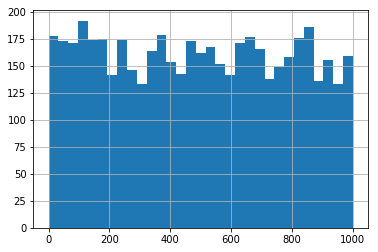

In [25]:
df_reps_vi["alpha_order_stat"].hist(bins=31);

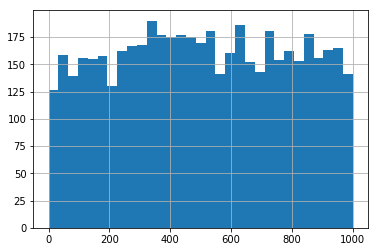

In [26]:
df_reps_vi["beta_order_stat"].hist(bins=31);

# Bootstrap (residual resampling)

In [27]:
X1 = np.hstack([np.ones((N, 1)), X[:, None]])
q, r = np.linalg.qr(X1)
invr = np.linalg.inv(r)
coeff1 = np.dot(invr, np.dot(q.T, y))
coeff2 = np.linalg.lstsq(X1, y)
print(coeff1, coeff2)

[-13.39516596  -1.43854951] (array([-13.39516596,  -1.43854951]), array([19.48602512]), 2, array([18.81620376,  4.77134254]))


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """


In [28]:
nboot = 1000
def glm_bootdist(X, y):
    X1 = np.hstack([np.ones((N, 1)), X[:, None]])
    q, r = np.linalg.qr(X1)
    invr = np.linalg.inv(r)
    coeff = np.dot(invr, np.dot(q.T, y))
    yhat = np.dot(X1, coeff)
    resid = y - yhat
    resid_s = resid[np.random.randint(0, 25, size=(N, nboot))]
    y_s = yhat[:, None] + resid_s
    coeff_s = np.dot(invr, np.dot(q.T, y_s))
    return coeff_s[0], coeff_s[1]

In [29]:
reps = np.zeros((num_reps, 8))
for i in range(num_reps):
    b, a, y = gen_func(X)
    apost, bpost = glm_bootdist(X, y)
    reps[i] = np.asarray([order_stat(a, apost), a,
                          rmse_averaged(a, apost),
                          rmse_mean(a, apost),
                          order_stat(b, bpost), b,
                          rmse_averaged(b, bpost),
                          rmse_mean(b, bpost)
                          ])

In [30]:
df_reps_bt = pd.DataFrame(reps, columns=['alpha_order_stat', 'alpha_prior',
                                      'alpha_rmse_averaged', 'alpha_rmse_mean',
                                      'beta_order_stat', 'beta_prior', 
                                      'beta_rmse_averaged', 'beta_rmse_mean'])
df_reps_bt.head()

,alpha_order_stat,alpha_prior,alpha_rmse_averaged,alpha_rmse_mean,beta_order_stat,beta_prior,beta_rmse_averaged,beta_rmse_mean
0,745.0,-8.037144,0.246976,0.137609,859.0,-11.529123,0.078992,0.059053
1,673.0,2.523151,0.307533,0.129099,672.0,-25.186322,0.081353,0.029809
2,718.0,-1.529589,0.345268,0.181087,668.0,0.119501,0.082185,0.030994
3,816.0,-7.743706,0.330177,0.223979,743.0,6.802125,0.079460,0.043546
4,545.0,-13.802770,0.311419,0.032280,596.0,8.352739,0.082436,0.016838


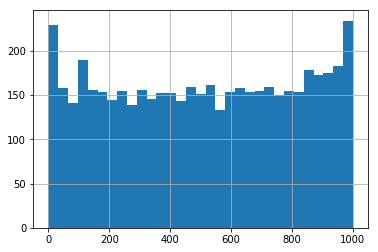

In [31]:
df_reps_bt["alpha_order_stat"].hist(bins=31);

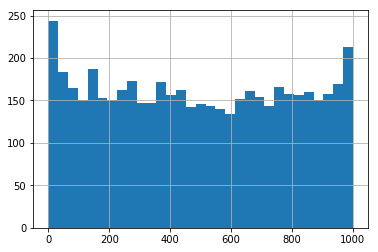

In [32]:
df_reps_bt["beta_order_stat"].hist(bins=31);

# Bootstrap (vector resampling)

In [40]:
nboot = 1000
def glm_bootdist2(X1, y):
    bt_vect = np.random.randint(0, 25, size=(nboot, N))
    apost = np.zeros(nboot)
    bpost = np.zeros(nboot)
    for i in range(nboot):
        X1b = X1[bt_vect[i],:]
        yb = y[bt_vect[i]]
        coeff2 = np.linalg.lstsq(X1b, yb)
        apost[i], bpost[i] = coeff2[0]
    return apost, bpost

In [41]:
reps = np.zeros((num_reps, 8))
X1 = np.hstack([np.ones((N, 1)), X[:, None]])
for i in range(num_reps):
    b, a, y = gen_func(X)
    apost, bpost = glm_bootdist2(X1, y)
    reps[i] = np.asarray([order_stat(a, apost), a,
                          rmse_averaged(a, apost),
                          rmse_mean(a, apost),
                          order_stat(b, bpost), b,
                          rmse_averaged(b, bpost),
                          rmse_mean(b, bpost)
                          ])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':


In [42]:
df_reps_bt2 = pd.DataFrame(reps, columns=['alpha_order_stat', 'alpha_prior',
                                      'alpha_rmse_averaged', 'alpha_rmse_mean',
                                      'beta_order_stat', 'beta_prior', 
                                      'beta_rmse_averaged', 'beta_rmse_mean'])
df_reps_bt2.head()

,alpha_order_stat,alpha_prior,alpha_rmse_averaged,alpha_rmse_mean,beta_order_stat,beta_prior,beta_rmse_averaged,beta_rmse_mean
0,453.0,-4.593623,0.215895,0.022390,546.0,-12.004934,0.059643,0.007328
1,147.0,-11.146769,0.410253,0.292018,26.0,14.993464,0.151508,0.133094
2,900.0,7.611507,0.354424,0.281817,50.0,-0.703960,0.134590,0.116500
3,697.0,1.967246,0.306042,0.132360,530.0,-6.311887,0.073330,0.012303
4,750.0,-17.815659,0.280552,0.153894,954.0,-11.268606,0.087035,0.072948


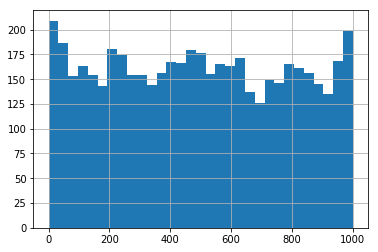

In [43]:
df_reps_bt2["alpha_order_stat"].hist(bins=31);

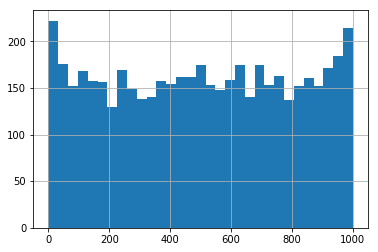

In [44]:
df_reps_bt2["beta_order_stat"].hist(bins=31);